# Collaborative Filtering을 활용한 상품 추천전략  
-----------------------------------------------------------------------------------

## 목차

* ### CF 알고리즘이란?

* ### 코드를 통한 시뮬레이션

* ### 결론 및 향후 개발 방향  

-----------------------------------------------------------------------------------

## 1. 협업필터링, Collaborative Filtering(CF)

1. 나와 가장 유사한 성향 지닌 사람을 기반으로 그 사람이 들은 아이템을 추천해주는 것

2. 내가 선호하는 아이템을 기반으로 가장 유사한 성향의 아이템을 추천해주는 것

In [287]:
cd C:\Users\user\Desktop\study\deep_learning

C:\Users\user\Desktop\study\deep_learning


In [288]:
import pandas as pd
from IPython.display import Image
from sklearn.metrics.pairwise import cosine_similarity

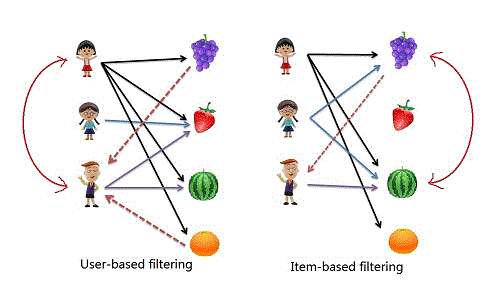

In [289]:
with open('./ref/2257D64755FDAFD425.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

#### 발생한 트랜잭션 로그를 불러옵니다

In [290]:
dataset = pd.read_csv("./dataset/shopping_log.csv",index_col=0)
dataset.head()

,user_id,category_id,product_id,action,product_price,product_count
time,,,,,,
2020-05-12 17:30:30,1,10,11,4,30000,20
2020-05-12 17:30:30,1,10,12,3,30000,20
2020-05-12 17:30:30,1,10,15,4,30000,20
2020-05-12 17:30:30,1,20,21,-1,30000,20
2020-05-12 17:30:30,1,10,11,4,30000,20


#### 데이터를 가공하여 상품의 정보와 상품에 따른 action으로 데이터를 분리합니다.

In [291]:
product_info = pd.read_csv("./dataset/product_info.csv",index_col=0)
product_info.head()

,product_price,product_count
product_id,,
11,30000,10
12,25000,40
13,17000,32
14,36000,1
15,29000,13


#### action을 해당 상품에 대한 user의 선호도라 생각하고 다음과 같이 수치화하였습니다  
* action
    + view = -1
    + click = 1
    + like = 2
    + cart = 3
    + purchase = 4

In [292]:
ratings = pd.read_csv("./dataset/shopping_log_mod.csv",index_col=0)
ratings.head()

,11,12,13,14,15,21,22,23,24,25,31,32,33,34,35
user_id,,,,,,,,,,,,,,,
1,4.0,3.0,NaN,NaN,4.0,-1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,-1.0,-1.0,NaN,NaN,-1.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,3.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN


In [296]:
r1 = ratings.iloc[:,[0,1,2,3,4]].T
r2 = ratings.iloc[:,[5,6,7,8,9]].T
r3 = ratings.iloc[:,[10,11,12,13,14]].T
m1=r1.fillna(0).mean()
m2=r2.fillna(0).mean()
m3=r3.fillna(0).mean()
r1=(r1.fillna(m1)).T
r2=(r2.fillna(m2)).T
r3=(r3.fillna(m3)).T

In [297]:
ratings=pd.merge(r1,r2,how='outer',left_index=True, right_index=True)
ratings=pd.merge(ratings,r3,how='outer',left_index=True, right_index=True)
ratings

,11,12,13,14,15,21,22,23,24,25,31,32,33,34,35
user_id,,,,,,,,,,,,,,,
1,4.0,3.0,2.2,2.2,4.0,-1.0,-0.2,-0.2,-0.2,-0.2,4.0,0.8,0.8,0.8,0.8
2,-1.0,-1.0,-0.6,-0.6,-1.0,4.0,3.0,1.4,1.4,1.4,0.0,0.0,0.0,0.0,0.0
3,4.0,3.0,2.0,2.2,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.8,0.8,0.8,0.8
4,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1.2,1.2,1.2,0.0,0.0,0.0,0.0,0.0
5,4.0,0.8,0.8,0.8,0.8,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.2,1.2,1.2
6,0.0,0.0,0.0,0.0,0.0,-0.2,-0.2,-0.2,-0.2,-1.0,0.0,0.0,0.0,0.0,0.0


####  주어진 데이터를 표준화하였습니다

In [298]:
def standardize(row):
    new_row = (row-row.mean())/(row.max()-row.min())
    return new_row

ratings_std = ratings.apply(standardize)
ratings_std.head()

,11,12,13,14,15,21,22,23,24,25,31,32,33,34,35
user_id,,,,,,,,,,,,,,,
1,0.433333,0.508333,0.523810,0.511905,0.606667,-0.426667,-0.302083,-0.354167,-0.354167,-0.180556,0.541667,0.011111,0.277778,0.277778,0.277778
2,-0.566667,-0.491667,-0.476190,-0.488095,-0.393333,0.573333,0.697917,0.645833,0.645833,0.486111,-0.458333,-0.255556,-0.388889,-0.388889,-0.388889
3,0.433333,0.508333,0.452381,0.511905,0.206667,-0.226667,-0.239583,-0.229167,-0.229167,-0.097222,0.541667,0.011111,0.277778,0.277778,0.277778
4,-0.366667,-0.241667,-0.261905,-0.273810,-0.193333,0.573333,0.385417,0.520833,0.520833,0.402778,-0.458333,-0.255556,-0.388889,-0.388889,-0.388889
5,0.433333,-0.041667,0.023810,0.011905,-0.033333,-0.226667,-0.239583,-0.229167,-0.229167,-0.097222,0.291667,0.744444,0.611111,0.611111,0.611111


#### 제품의 유사성을 알기 위해 상관관계를 구했습니다

In [302]:
item_similarity = cosine_similarity(ratings_std.T)
item_similarity_df = pd.DataFrame(item_similarity, index = ratings.columns, columns = ratings.columns)
item_similarity_df.head()

,11,12,13,14,15,21,22,23,24,25,31,32,33,34,35
11,1.000000,0.873296,0.907630,0.902873,0.817015,-0.757275,-0.737089,-0.709980,-0.709980,-0.437694,0.972429,0.714239,0.950343,0.950343,0.950343
12,0.873296,1.000000,0.995124,0.997415,0.935553,-0.719880,-0.694957,-0.673740,-0.673740,-0.441366,0.922104,0.282826,0.685601,0.685601,0.685601
13,0.907630,0.995124,1.000000,0.998347,0.950414,-0.740647,-0.706209,-0.688116,-0.688116,-0.442260,0.948496,0.357127,0.741404,0.741404,0.741404
14,0.902873,0.997415,0.998347,1.000000,0.933134,-0.728981,-0.697579,-0.678403,-0.678403,-0.433843,0.947490,0.344342,0.733838,0.733838,0.733838
15,0.817015,0.935553,0.950414,0.933134,1.000000,-0.723104,-0.666330,-0.660868,-0.660868,-0.437549,0.862678,0.264599,0.641416,0.641416,0.641416


In [266]:
# 상품간의 유사도를 계산하는 함수
def get_similar_product(product_name, user_rating):
    similar_score = item_similarity_df[product_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

print(get_similar_product("11",4))

11    1.500000
31    1.458644
34    1.425515
33    1.425515
35    1.425515
13    1.361445
14    1.354310
12    1.309944
15    1.225522
32    1.071358
25   -0.656541
24   -1.064971
23   -1.064971
22   -1.105633
21   -1.135912
Name: 11, dtype: float64


-----------------------------------------------------------------------------------
## 2. 시뮬레이션

결과를 쉽게 보기 위해 10번대 상품을 구입한 고객을 20번대 상품을 기피하고

30번대 상품을 선호하는 경향성을 띄게 만들었습니다.

* testcase : 11번을 장바구니에 넣고 33번을 구매한 고객이 선호할 만한 상품을 추천해보자

In [308]:
customer = [("11",3),("33",4)]
similar_product=pd.DataFrame()

for product, rating in customer:
    similar_product=similar_product.append(get_similar_product(product,rating),
                                           ignore_index=True)
product_info['preference'] = list(similar_product.sum())
product_info

,product_price,product_count,preference
product_id,,,
11,30000,10,1.925515
12,25000,40,1.465050
13,17000,32,1.565922
14,36000,1,1.552194
15,29000,13,1.370632
21,17000,25,-1.374680
22,11000,30,-1.310166
23,90000,5,-1.270728
24,8500,100,-1.270728


In [309]:
product_info.sort_values(['preference','product_count','product_price'],
                         ascending=[False,True,True]).head(10)

,product_price,product_count,preference
product_id,,,
35,10000,2,1.975172
34,49000,2,1.975172
33,15000,20,1.975172
11,30000,10,1.925515
31,36000,30,1.831521
32,24000,25,1.684216
13,17000,32,1.565922
14,36000,1,1.552194
12,25000,40,1.465050


-----------------------------------------------------------------------------------
## 3. 결론 및 향후 개발 방향

이처럼 주어진 가정에 맞는 데이터를 뽑는 것에는 성공하였습니다. 시뮬레이션을 직접하면서

작은 파라미터를 정하는 것에도 많은 시간을 들이며 신중해야함을 배울 수 있었습니다.

그러나 위 알고리즘으로는 cold start problem을 해결할 수 없으므로 다른 해결책을 찾아야합니다.

이를 새로운 카테고리의 상품이 생겼을 때 기존의 상품과의 이미지 유사도를 구하는

CNN을 구축하여 해결할 수 있을 것이라 생각됩니다. 감사합니다.

### ¶이미지 출처: https://hackersstudy.tistory.com/126